In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch import nn

> #### Our toy dataset

+ We'll import `make_circles()` from `sklearn.datasets` which can be used as a simple toy dataset to visualize clustering and classification algorithms<br><br>
+ This dataset is actually a large circle containing a smaller circle in 2d<br><br>

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, random_state=42, noise=0.03)

In [5]:
circles_df = pd.DataFrame({"X_1": X[:, 0], "X_2": X[:, 1], "y": y})

circles_df.head()

,X_1,X_2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


> #### Getting a look of the data

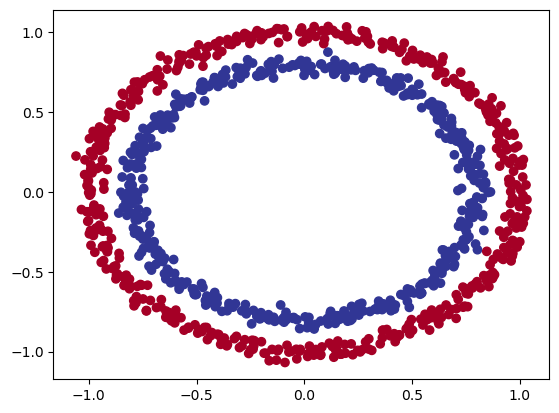

In [6]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

> #### Splitting the dataset

In [7]:
X = torch.from_numpy(X).type(torch.float32)

y = torch.from_numpy(y).type(torch.float32)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> #### Creating our model

In [9]:
class CircleModel_Version_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))

In [12]:
def accuracy_fn(y_pred, y_true):
    correct_preds = torch.eq(y_pred, y_true).sum().item()
    accuracy = (correct_preds/len(y_pred)) * 100
    return accuracy

In [11]:
model_0 = CircleModel_Version_0()

learning_rate = 0.01
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=learning_rate)

> #### Training loop

In [12]:
epoch_count = []
train_loss_values = []
test_loss_values = []
train_accuracy_values = []

epochs = 1000

for epoch in range(epochs):
    model_0.train()
    
    raw_probs = model_0(X_train).squeeze()
    sigmoid_output = torch.sigmoid(raw_probs)
    y_preds = (sigmoid_output >= 0.5).float()
    train_loss = loss_fn(raw_probs, y_train).requires_grad_(requires_grad=True)
    train_acc = accuracy_fn(y_preds.squeeze(), y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model_0.eval()
    
    with torch.inference_mode():
        test_preds = (torch.sigmoid(model_0(X_test)) >= 0.5).float()  
        test_loss = loss_fn(model_0(X_test).squeeze(), y_test)
        test_acc = accuracy_fn(test_preds.squeeze(), y_test)
    
    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        train_accuracy_values.append(train_acc)
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")
        print(f"| Train Accuracy: {train_acc} | Test Accuracy: {test_acc}")

Epoch: 0 | Train Loss: 0.7090821266174316 | Test Loss: 0.7122061252593994
| Train Accuracy: 50.0 | Test Accuracy: 50.0
Epoch: 100 | Train Loss: 0.6978985667228699 | Test Loss: 0.7002844214439392
| Train Accuracy: 50.0 | Test Accuracy: 50.0
Epoch: 200 | Train Loss: 0.6945585608482361 | Test Loss: 0.69643235206604
| Train Accuracy: 50.0 | Test Accuracy: 50.0
Epoch: 300 | Train Loss: 0.6935492157936096 | Test Loss: 0.6951392889022827
| Train Accuracy: 46.25 | Test Accuracy: 40.0
Epoch: 400 | Train Loss: 0.6932298541069031 | Test Loss: 0.6946876645088196
| Train Accuracy: 48.25 | Test Accuracy: 48.5
Epoch: 500 | Train Loss: 0.6931171417236328 | Test Loss: 0.6945288777351379
| Train Accuracy: 49.25 | Test Accuracy: 47.0
Epoch: 600 | Train Loss: 0.6930691599845886 | Test Loss: 0.6944795250892639
| Train Accuracy: 50.125 | Test Accuracy: 47.0
Epoch: 700 | Train Loss: 0.6930435299873352 | Test Loss: 0.6944736242294312
| Train Accuracy: 50.5 | Test Accuracy: 47.0
Epoch: 800 | Train Loss: 0.6930

> #### Function for visualizing decision boundary

In [3]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y."""


    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

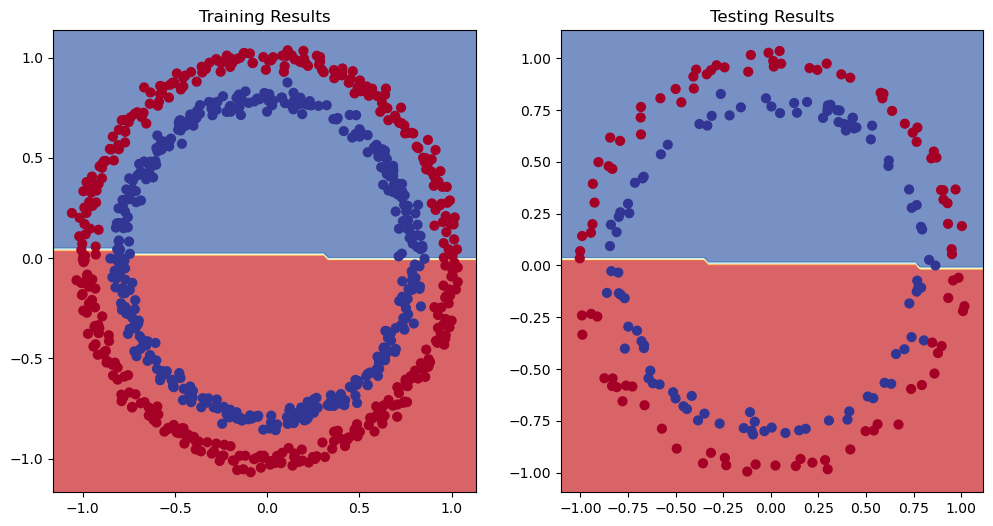

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Training Results")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing Results")
plot_decision_boundary(model_0, X_test, y_test)

plt.show()

> ### Creating a new and improved model

+ Following are common ways to improve a deep learning model:
    + Add more layers
        + This will give the model more chance to learn about pattersn in data<br><br>
    + Add more neurons<br><br>
    + Fit for longer<br><br>
    + Add or try different activation functions<br><br>
    + Try different learning rates<br><br>

In [15]:
class CircleModel_Version_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [16]:
model_1 = CircleModel_Version_1()

learning_rate = 0.01
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=learning_rate)

In [17]:
torch.manual_seed(42)

epoch_count = []
train_loss_values = []
test_loss_values = []
train_accuracy_values = []

epochs = 1000

for epoch in range(epochs):
    model_1.train()
    
    raw_probs = model_1(X_train).squeeze()
    sigmoid_output = torch.sigmoid(raw_probs)
    y_preds = (sigmoid_output >= 0.5).float()
    train_loss = loss_fn(raw_probs, y_train).requires_grad_(requires_grad=True)
    train_acc = accuracy_fn(y_preds.squeeze(), y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model_1.eval()
    
    with torch.inference_mode():
        test_preds = (torch.sigmoid(model_1(X_test)) >= 0.5).float()  
        test_loss = loss_fn(model_1(X_test).squeeze(), y_test)
        test_acc = accuracy_fn(test_preds.squeeze(), y_test)
    
    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        train_accuracy_values.append(train_acc)
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")
        print(f"| Train Accuracy: {train_acc} | Test Accuracy: {test_acc}")

Epoch: 0 | Train Loss: 0.6995424032211304 | Test Loss: 0.7046959400177002
| Train Accuracy: 50.0 | Test Accuracy: 50.0
Epoch: 100 | Train Loss: 0.6952443718910217 | Test Loss: 0.6995972990989685
| Train Accuracy: 57.62500000000001 | Test Accuracy: 54.0
Epoch: 200 | Train Loss: 0.6938817501068115 | Test Loss: 0.6977412700653076
| Train Accuracy: 53.37499999999999 | Test Accuracy: 50.0
Epoch: 300 | Train Loss: 0.6934102773666382 | Test Loss: 0.6969321966171265
| Train Accuracy: 52.125 | Test Accuracy: 49.5
Epoch: 400 | Train Loss: 0.6932278275489807 | Test Loss: 0.6965007185935974
| Train Accuracy: 51.74999999999999 | Test Accuracy: 47.0
Epoch: 500 | Train Loss: 0.6931452751159668 | Test Loss: 0.6962226033210754
| Train Accuracy: 51.625 | Test Accuracy: 46.5
Epoch: 600 | Train Loss: 0.6931003332138062 | Test Loss: 0.6960177421569824
| Train Accuracy: 51.125 | Test Accuracy: 47.0
Epoch: 700 | Train Loss: 0.6930716037750244 | Test Loss: 0.6958542466163635
| Train Accuracy: 51.5 | Test Accu

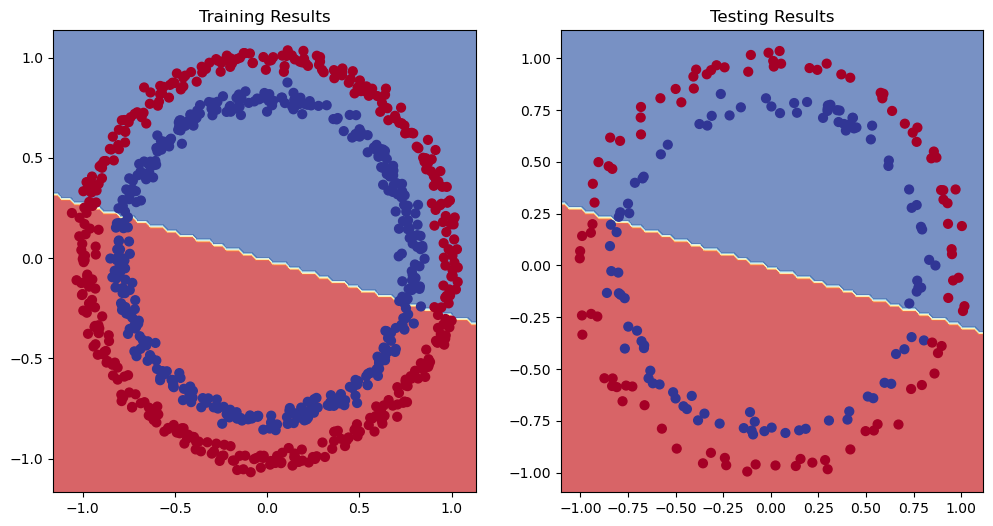

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Training Results")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing Results")
plot_decision_boundary(model_1, X_test, y_test)

plt.show()

> ### Introducing the activation function (ReLU)

In [19]:
class CircleModel_Version_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [20]:
model_2 = CircleModel_Version_2()

learning_rate = 0.1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=learning_rate)

In [21]:
torch.manual_seed(42)

epoch_count = []
train_loss_values = []
test_loss_values = []
train_accuracy_values = []

epochs = 2000

for epoch in range(epochs):
    model_2.train()
    
    raw_probs = model_2(X_train).squeeze()
    sigmoid_output = torch.sigmoid(raw_probs)
    y_preds = (sigmoid_output >= 0.5).float()
    train_loss = loss_fn(raw_probs, y_train).requires_grad_(requires_grad=True)
    train_acc = accuracy_fn(y_preds.squeeze(), y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model_2.eval()
    
    with torch.inference_mode():
        test_preds = (torch.sigmoid(model_2(X_test)) >= 0.5).float()  
        test_loss = loss_fn(model_2(X_test).squeeze(), y_test)
        test_acc = accuracy_fn(test_preds.squeeze(), y_test)
    
    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        train_accuracy_values.append(train_acc)
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")
        print(f"| Train Accuracy: {train_acc} | Test Accuracy: {test_acc}")

Epoch: 0 | Train Loss: 0.6929463148117065 | Test Loss: 0.6931881904602051
| Train Accuracy: 50.0 | Test Accuracy: 50.0
Epoch: 100 | Train Loss: 0.691152811050415 | Test Loss: 0.6910240054130554
| Train Accuracy: 52.87500000000001 | Test Accuracy: 52.5
Epoch: 200 | Train Loss: 0.6897743940353394 | Test Loss: 0.6893961429595947
| Train Accuracy: 53.37499999999999 | Test Accuracy: 55.00000000000001
Epoch: 300 | Train Loss: 0.687949538230896 | Test Loss: 0.6872316598892212
| Train Accuracy: 53.0 | Test Accuracy: 56.00000000000001
Epoch: 400 | Train Loss: 0.6851677894592285 | Test Loss: 0.684114933013916
| Train Accuracy: 52.75 | Test Accuracy: 56.49999999999999
Epoch: 500 | Train Loss: 0.6810224652290344 | Test Loss: 0.6794120669364929
| Train Accuracy: 52.75 | Test Accuracy: 56.49999999999999
Epoch: 600 | Train Loss: 0.675148606300354 | Test Loss: 0.6728507876396179
| Train Accuracy: 54.50000000000001 | Test Accuracy: 56.00000000000001
Epoch: 700 | Train Loss: 0.6665886640548706 | Test Lo

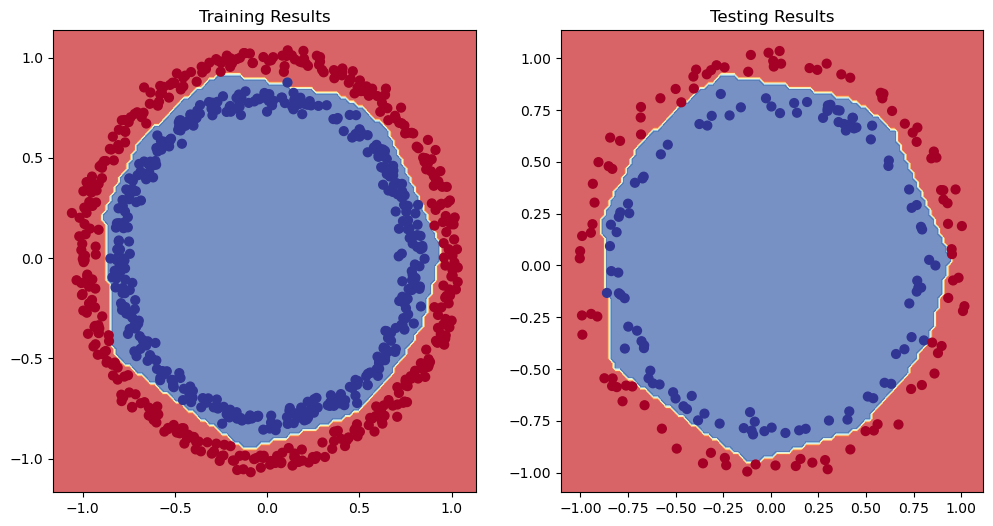

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Training Results")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing Results")
plot_decision_boundary(model_2, X_test, y_test)

plt.show()

> ## Multiclass Classification

> #### Datatset

In [4]:
from sklearn.datasets import make_blobs

X_blob, y_blob = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5,
                           random_state=42)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

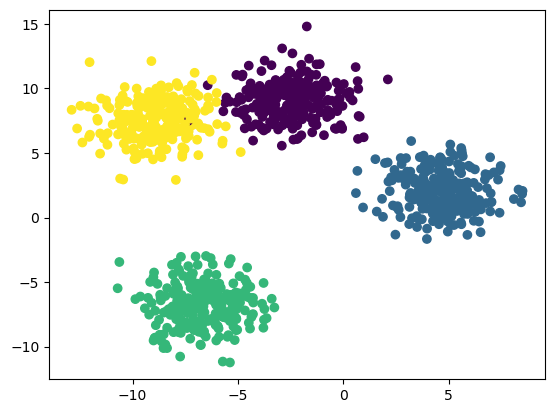

In [5]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                       test_size=0.2,
                                                                       random_state=42)

In [13]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [30]:
blob_model = BlobModel(input_features=2, 
                    output_features=4, 
                    hidden_units=8)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blob_model.parameters(), 
                            lr=0.01)

blob_model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [31]:
torch.manual_seed(42)

epoch_count = []
train_loss_values = []
test_loss_values = []

epochs = 100

for epoch in range(epochs):
    blob_model.train()

    raw_train = blob_model(X_blob_train)
    pred_labels_train = torch.softmax(raw_train, dim=1).argmax(dim=1)
    loss = loss_fn(raw_train, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=pred_labels_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()
    with torch.inference_mode():
        raw_test = blob_model(X_blob_test)
        pred_labels_test = torch.softmax(raw_test, dim=1).argmax(dim=1)
        test_loss = loss_fn(raw_test, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=pred_labels_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")
        print(f"| Train Accuracy: {acc} | Test Accuracy: {test_acc}")

Epoch: 0 | Train Loss: 1.0432370901107788 | Test Loss: 0.963351309299469
| Train Accuracy: 65.5 | Test Accuracy: 71.0
Epoch: 10 | Train Loss: 0.6368808746337891 | Test Loss: 0.6122151613235474
| Train Accuracy: 79.5 | Test Accuracy: 88.0
Epoch: 20 | Train Loss: 0.4694470465183258 | Test Loss: 0.45864734053611755
| Train Accuracy: 97.75 | Test Accuracy: 98.0
Epoch: 30 | Train Loss: 0.37339234352111816 | Test Loss: 0.3677147924900055
| Train Accuracy: 98.5 | Test Accuracy: 99.0
Epoch: 40 | Train Loss: 0.31008732318878174 | Test Loss: 0.3065946102142334
| Train Accuracy: 98.625 | Test Accuracy: 99.0
Epoch: 50 | Train Loss: 0.2648567259311676 | Test Loss: 0.26227450370788574
| Train Accuracy: 98.875 | Test Accuracy: 99.0
Epoch: 60 | Train Loss: 0.23081865906715393 | Test Loss: 0.2285250425338745
| Train Accuracy: 98.875 | Test Accuracy: 99.5
Epoch: 70 | Train Loss: 0.20428617298603058 | Test Loss: 0.20196585357189178
| Train Accuracy: 99.125 | Test Accuracy: 99.5
Epoch: 80 | Train Loss: 0.

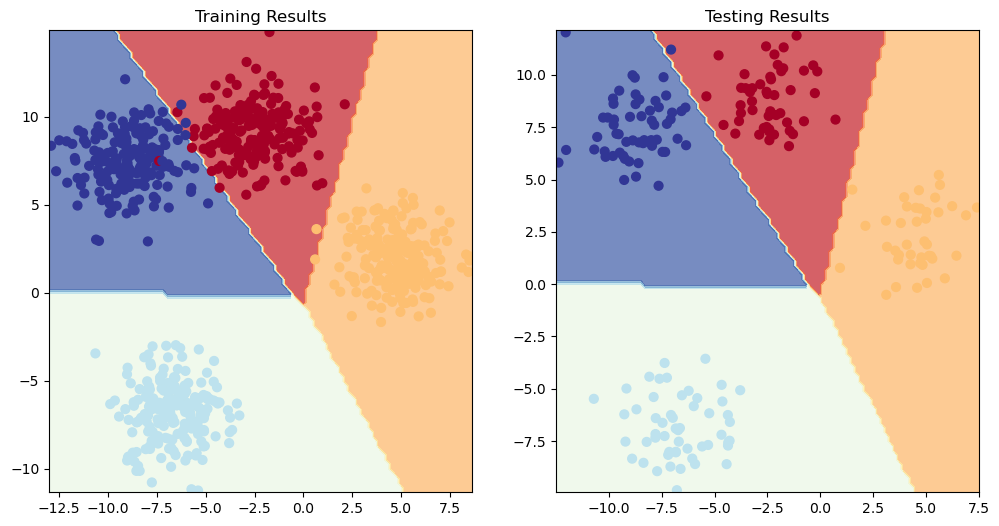

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Training Results")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Testing Results")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)
plt.show()

plt.show()